<a href="https://colab.research.google.com/github/sandeep0412/Data-Imputation-on-Psychology-Data/blob/master/Depth_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Load the Drive helper and mount
from google.colab import drive
# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import pandas as pd
from prettytable import PrettyTable
import random
from math import floor
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [0]:
#Standardize numerical Values
def standardize_col(col):
    return (col - col.min()) * 1.0 / (col.max() - col.min())


In [0]:
#order the columns of the dataframe according to decreasing number of null values, return list of column names
def ordered_cols(df):
  x = df.isna().sum()
  x = x.sort_values()
  x = x.to_frame()
  columns_sorted = x.index.values
  return list(columns_sorted)

In [0]:
class DecisionTree(object):
    """
    Class to create decision tree model (CART)
    """
    def __init__(self, _max_depth, _min_splits):
        self.max_depth = _max_depth
        self.min_splits = _min_splits

    def fit(self, _feature, _label):
        """
        :param _feature:
        :param _label:
        :return:
        """
        self.feature = _feature
        self.label = _label
        self.train_data = np.column_stack((self.feature,self.label))
        self.build_tree()


    def compute_gini_similarity(self, groups, class_labels):
        """
        compute the gini index for the groups and class labels
        :param groups:
        :param class_labels:
        :return:
        """
        num_sample = sum([len(group) for group in groups])
        gini_score = 0

        for group in groups:
            size = float(len(group))

            if size == 0:
                continue
            score = 0.0
            for label in class_labels:
                porportion = (group[:,-1] == label).sum() / size
                score += porportion * porportion
            gini_score += (1.0 - score) * (size/num_sample)

        return gini_score

    def terminal_node(self, _group):
        """
        Function set terminal node as the most common class in the group to make prediction later on
        is an helper function used to mark the leaf node in the tree based on the early stop condition
        or actual stop condition which ever is meet early
        :param _group:
        :return:
        """
        class_labels, count = np.unique(_group[:,-1], return_counts= True)
        return class_labels[np.argmax(count)]

    def split(self, index, val, data):
        """
        split features into two groups based on their values
        :param index:
        :param val:
        :param data:
        :return:
        """
        data_left = np.array([]).reshape(0,self.train_data.shape[1])
        data_right = np.array([]).reshape(0, self.train_data.shape[1])

        for row in data:
            if row[index] <= val :
                data_left = np.vstack((data_left,row))

            if row[index] > val:
                data_right = np.vstack((data_right, row))

        return data_left, data_right

    def best_split(self, data):
        """
        find the best split information using the gini score
        :param data:
        :return best_split result dict:
        """
        class_labels = np.unique(data[:,-1])
        best_index = 999
        best_val = 999
        best_score = 999
        best_groups = None

        for idx in range(data.shape[1]-1):
            for row in data:
                groups = self.split(idx, row[idx], data)
                gini_score = self.compute_gini_similarity(groups,class_labels)

                if gini_score < best_score:
                    best_index = idx
                    best_val = row[idx]
                    best_score = gini_score
                    best_groups = groups
        result = {}
        result['index'] = best_index
        result['val'] = best_val
        result['groups'] = best_groups
        return result


    def split_branch(self, node, depth):
        """
        recursively split the data and
        check for early stop argument based on self.max_depth and self.min_splits
        - check if left or right groups are empty is yess craete terminal node
        - check if we have reached max_depth early stop condition if yes create terminal node
        - Consider left node, check if the group is too small using min_split condition
            - if yes create terminal node
            - else continue to build the tree
        - same is done to the right side as well.
        else
        :param node:
        :param depth:
        :return:
        """
        left_node , right_node = node['groups']
        del(node['groups'])

        if not isinstance(left_node,np.ndarray) or not isinstance(right_node,np.ndarray):
            node['left'] = self.terminal_node(left_node + right_node)
            node['right'] = self.terminal_node(left_node + right_node)
            return

        if depth >= self.max_depth:
            node['left'] = self.terminal_node(left_node)
            node['right'] = self.terminal_node(right_node)
            return

        if len(left_node) <= self.min_splits:
            node['left'] = self.terminal_node(left_node)
        else:
            node['left'] = self.best_split(left_node)
            self.split_branch(node['left'],depth + 1)


        if len(right_node) <= self.min_splits:
            node['right'] = self.terminal_node(right_node)
        else:
            node['right'] = self.best_split(right_node)
            self.split_branch(node['right'],depth + 1)

    def build_tree(self):
        """
        build tree recursively with help of split_branch function
         - Create a root node
         - call recursive split_branch to build the complete tree
        :return:
        """
        self.root = self.best_split(self.train_data)
        self.split_branch(self.root, 1)
        return self.root

    def _predict(self, node, row):
        """
        Recursively traverse through the tress to determine the
        class of unseen sample data point during prediction
        :param node:
        :param row:
        :return:
        """
        if row[node['index']] < node['val']:
            if isinstance(node['left'], dict):
                return self._predict(node['left'], row)
            else:
                return node['left']

        else:
            if isinstance(node['right'],dict):
                return self._predict(node['right'],row)
            else:
                return node['right']

    def predict(self, test_data):
        """
        predict the set of data point
        :param test_data:
        :return:
        """
        self.predicted_label = np.array([])
        for idx in test_data:
            self.predicted_label = np.append(self.predicted_label, self._predict(self.root,idx))

        return self.predicted_label

In [0]:
def depth(df):
  #initial imputed values
  
  Z = np.matrix(df['previous_session_id']).reshape(-1,1)
  indexes_dict = {}
  
  #Get ordered list of col names except the session id which is always filled
  col_partial = ordered_cols(df.loc[:, df.columns != 'previous_session_id'])
  col_list = col_partial
#   print(col_partial)
  
  col_count = 50
  for col in col_partial:
  #   print(col)
    y  = df[col]
  #   print(type(y))
    pos = list(y[y.isnull()].index)
  #   print(pos)
    indexes_dict[col] = pos

    X_train = np.delete(Z, pos, axis=0)
    X_test = Z[pos, :]
    y_train = np.matrix(y.drop(y.index[pos])).reshape(Z.shape[0]-len(pos),1)

    y_final = np.matrix(y).reshape(Z.shape[0],1)

  #   print(y.values.reshape(Z.shape[0],1)[pos[0]])
  #   X_test = Z.loc[pos].values#.reshape(1,-1)
  #   y_train = (y.drop(y.index[pos])).values(columns = 1)
  #   X_train = (Z.drop(Z.index[pos])).values
  #   X_train = (X_train).values#.reshape(-1,1)
    
    #for validation
    x_train, x_test, y_temp_train, y_temp_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
    #Loop for depth
    depth_list = [1,2,5,8,10,20,25,50,100]
    errors = []
    train_errors = []
    for d in depth_list:
#       print(d)
      clf = tree.DecisionTreeRegressor(max_depth=d)
      clf = clf.fit(x_train, y_temp_train)

      predicted = clf.predict(x_test)
      errors.append(mean_squared_error(y_temp_test,predicted))
#       print(mean_absolute_error(y_temp_test,predicted))
      predicted = clf.predict(x_train)
      train_errors.append(mean_squared_error(y_temp_train,predicted))
      
    plt.figure()
    plt.plot(depth_list, errors, 'r', label="test_error")
    plt.plot(depth_list, train_errors, 'b', label="train_error")
    plt.xlabel('depth')  
    plt.ylabel('rmse') 
    plt.title('depth vs rmse for :' + col)
    plt.legend()
    plt.show()
    
    col_count -= 1
    if col_count==0:
      break
      
    clf = tree.DecisionTreeRegressor(max_depth=d)
    clf = clf.fit(X_train, y_train)
    predicted = clf.predict(X_test)
  #   print(predicted)

    for i in range(len(pos)):
      ind = pos[i]
      y_final[ind] = predicted[i]

    Z = np.concatenate((Z,y_final),axis = 1)
  #   break
  
  
  
  
#   #Converge 10 times
#   for l in range(10):
#     for colm in range(1,Z.shape[1]):
#       column_name = col_partial[colm-1]
#       pos = indexes_dict[column_name]

#       X_train = np.delete(Z, colm, axis=1)
#       X_train = np.delete(X_train, pos, axis=0)
#       X_test = np.delete(Z[pos, :], colm, axis=1)
#       y_train = Z[:, colm]
#       y_train = np.delete(y_train, pos, axis=0)

#   #     print(X_train.shape)
#   #     print(X_test.shape)
#   #     print(y_train.shape)

#       clf = tree.DecisionTreeRegressor()
#       clf = clf.fit(X_train, y_train)

#       predicted = clf.predict(X_test)

#       for i in range(len(pos)):
#         ind = pos[i]
#         Z[ind, colm] = predicted[i]
  
#   col_list = ['previous_session_id'] + col_list
# #   print(col_list)
#   return pd.DataFrame(Z, columns=col_list)

In [0]:
data_num=pd.read_csv("/content/drive/My Drive/data_num.csv",encoding='unicode_escape')
num_samples, column_size = data_num.shape

In [0]:
for col in data_num.columns:
    data_num[col] = standardize_col(data_num[col])

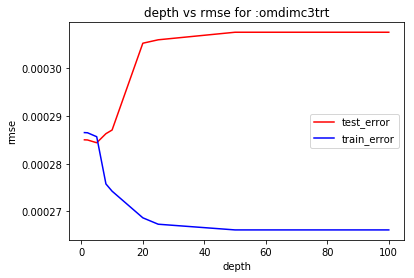

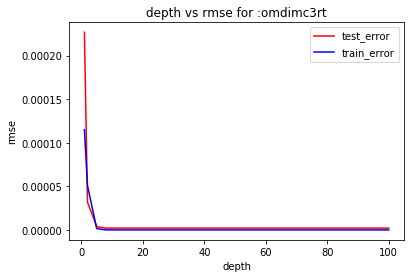

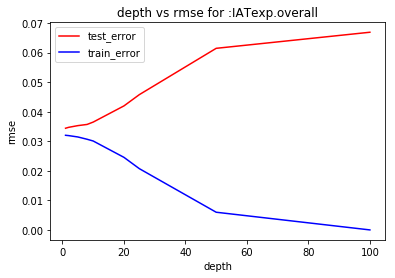

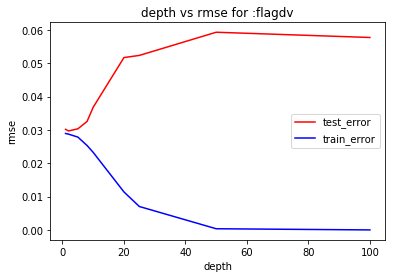

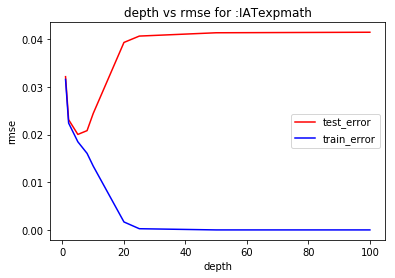

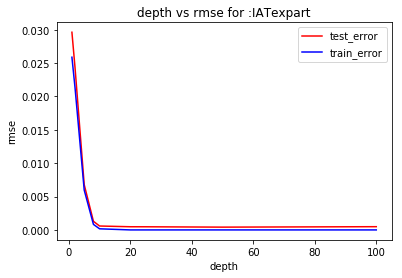

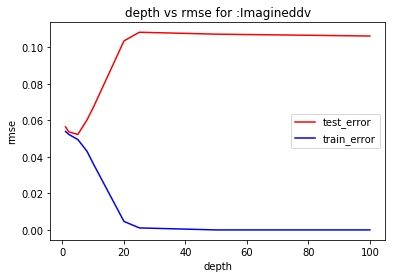

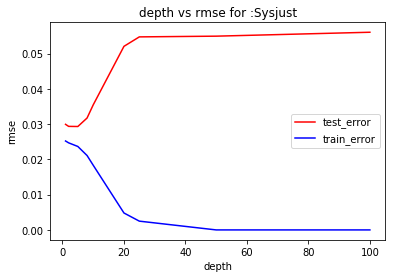

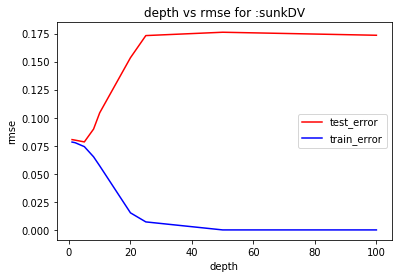

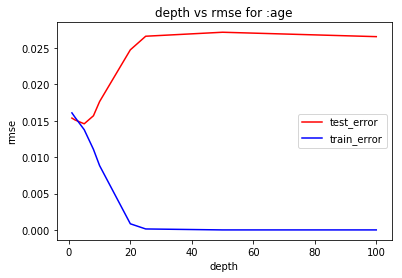

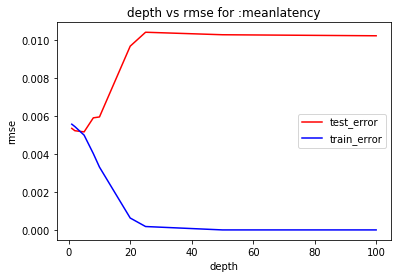

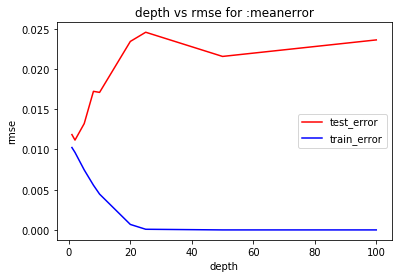

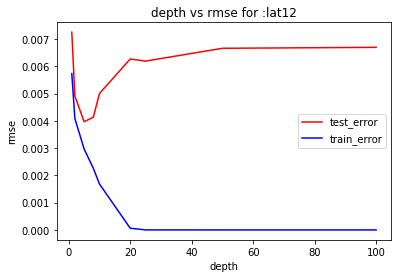

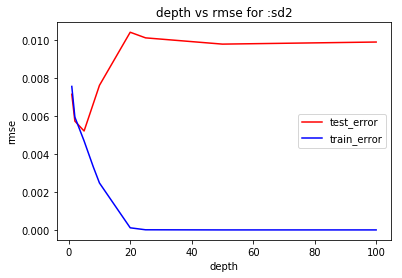

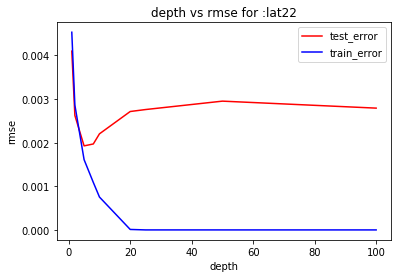

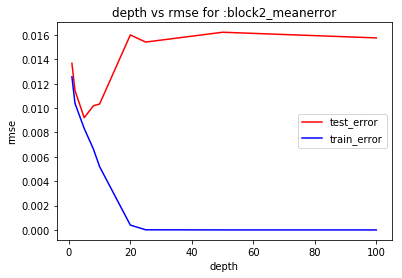

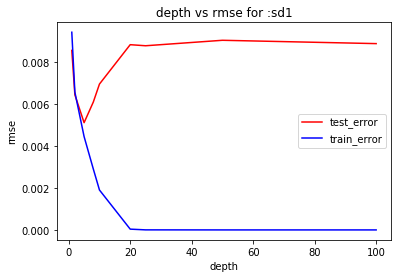

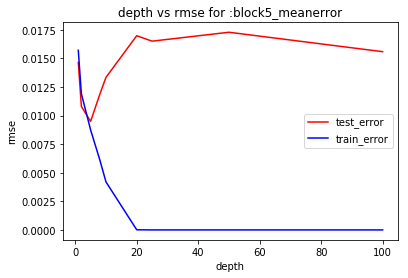

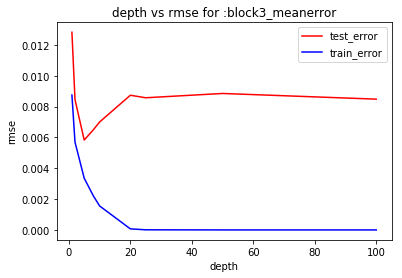

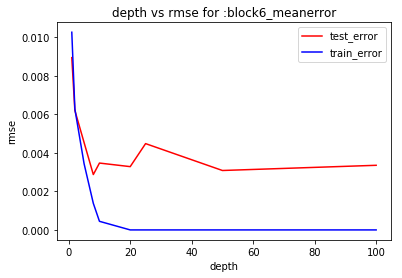

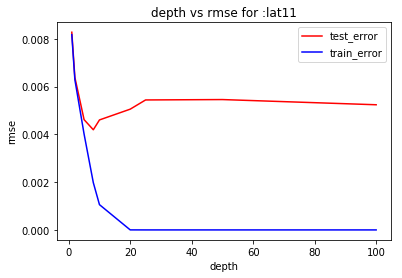

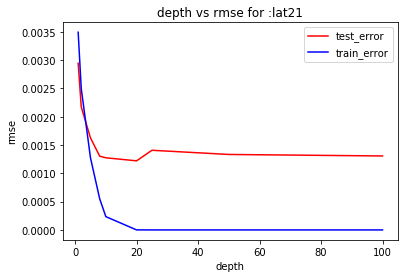

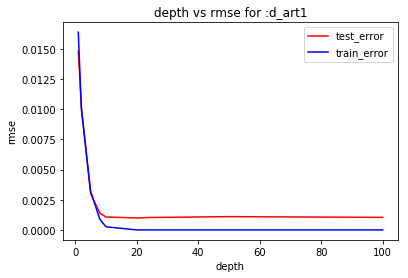

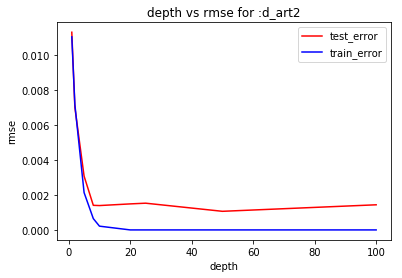

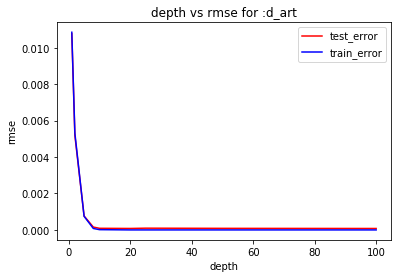

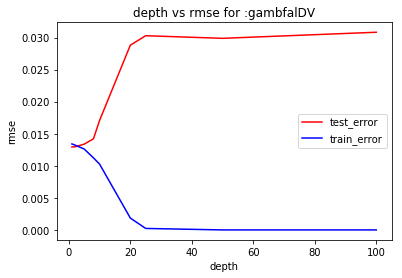

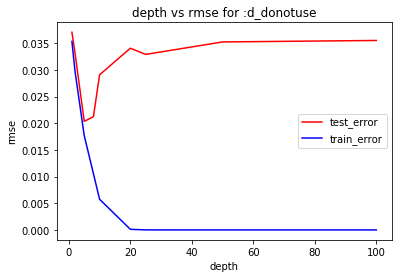

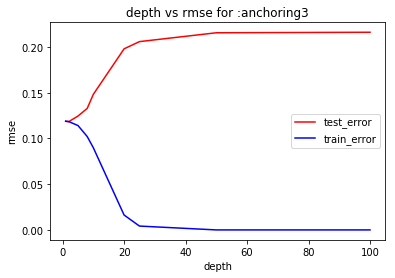

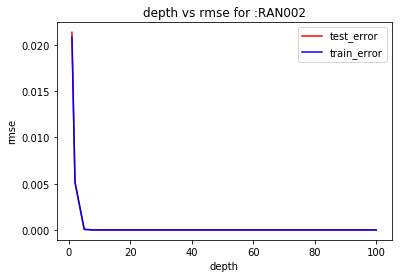

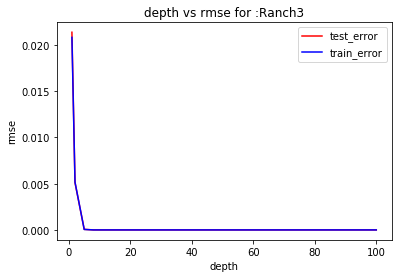

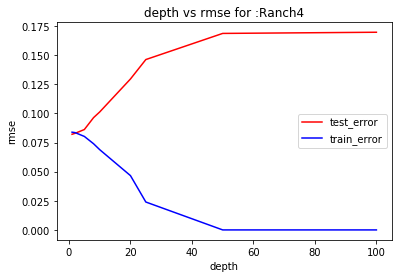

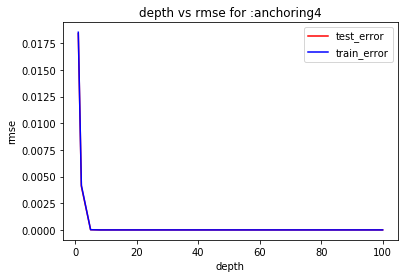

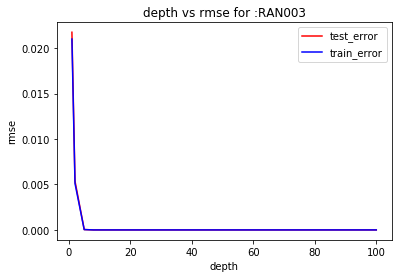

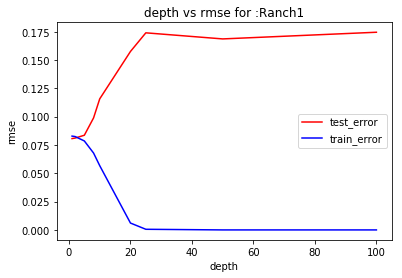

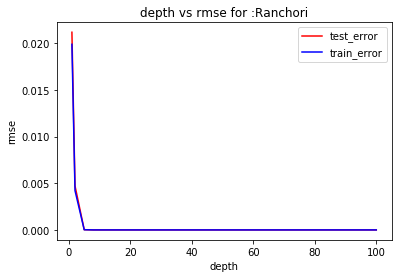

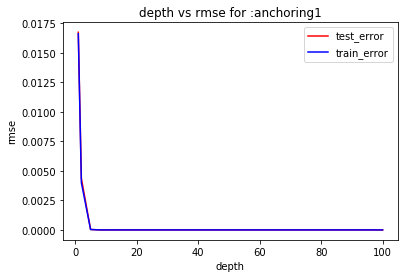

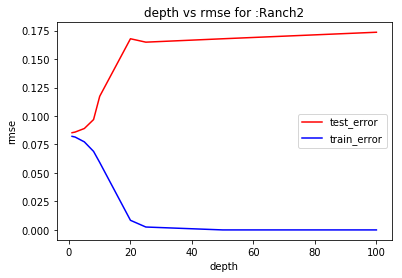

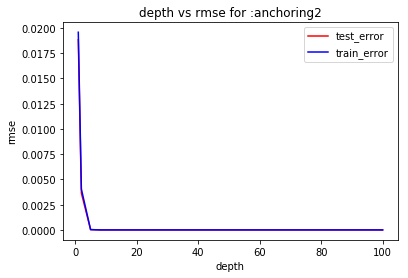

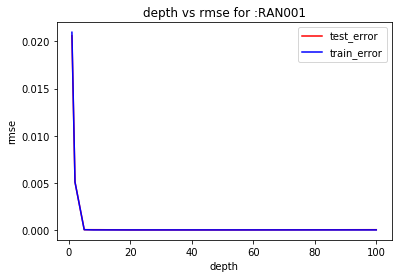

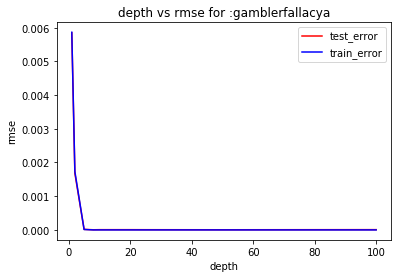

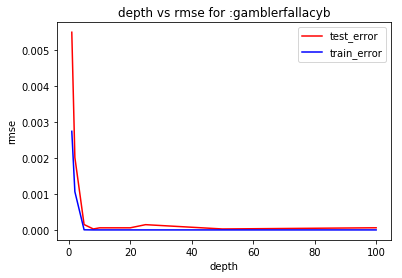

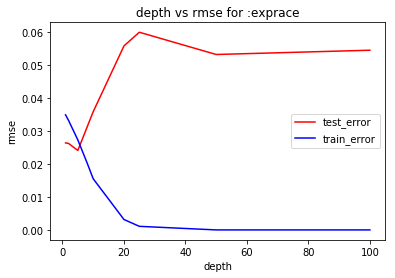

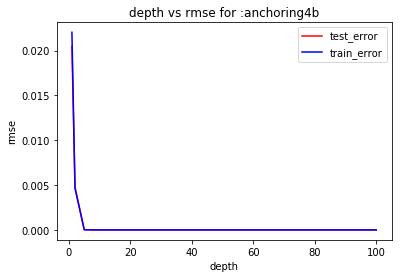

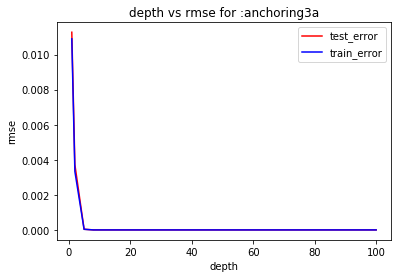

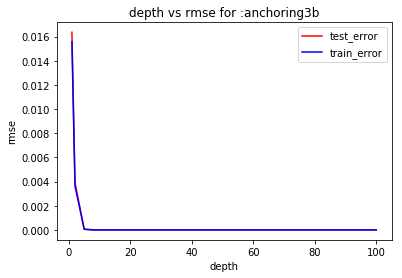

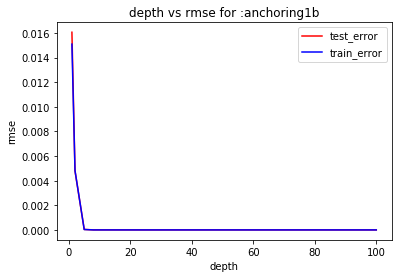

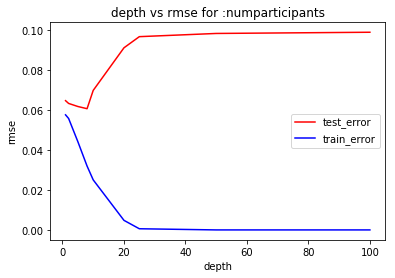

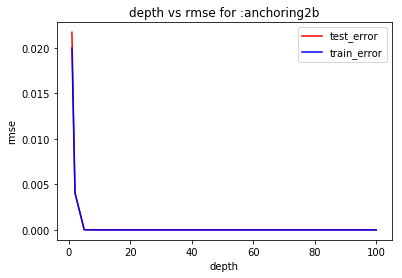

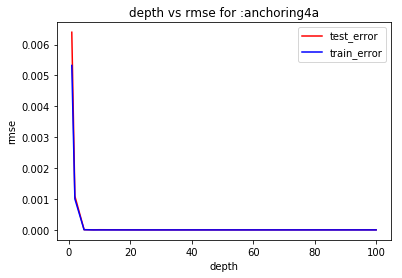

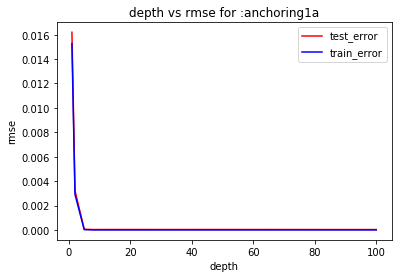

In [0]:
depth(data_num)